# Complete Guide to Static Panel Models

This notebook provides a comprehensive guide to **static panel data models** in PanelBox, covering all five estimators and when to use each.

## What You'll Learn

- ✅ All 5 static panel models (Pooled OLS, Between, Fixed Effects, Random Effects, First Difference)
- ✅ When to use each model
- ✅ Specification tests (F-test, Hausman test)
- ✅ Robust standard errors (8 types)
- ✅ Model comparison and interpretation
- ✅ Report generation (HTML, Markdown, LaTeX)

## Table of Contents

1. [Introduction to Static Panel Models](#introduction)
2. [Data Preparation](#data-preparation)
3. [The Five Models](#five-models)
   - 3.1 [Pooled OLS](#pooled-ols)
   - 3.2 [Between Estimator](#between)
   - 3.3 [Fixed Effects](#fixed-effects)
   - 3.4 [Random Effects](#random-effects)
   - 3.5 [First Difference](#first-difference)
4. [Specification Tests](#specification-tests)
5. [Robust Standard Errors](#robust-se)
6. [Model Comparison](#model-comparison)
7. [Report Generation](#report-generation)
8. [Decision Guide](#decision-guide)

---

## 1. Introduction to Static Panel Models {#introduction}

### What are Static Panel Models?

**Static panel models** are used when:
- No lagged dependent variable on the right-hand side
- Focus on contemporaneous relationships
- Want to control for unobserved heterogeneity

### General Form:

$$y_{it} = \alpha + \beta' X_{it} + u_{it}$$

Where:
- $y_{it}$: Dependent variable for entity $i$ at time $t$
- $X_{it}$: Vector of independent variables
- $u_{it}$: Error term

### Error Structure:

The key difference between models is how they handle the error term:

$$u_{it} = \alpha_i + \varepsilon_{it}$$

Where:
- $\alpha_i$: Entity-specific time-invariant effect (unobserved heterogeneity)
- $\varepsilon_{it}$: Idiosyncratic error

### The Five Models:

| Model | Assumption about $\alpha_i$ | Use Case |
|-------|------------------------|----------|
| **Pooled OLS** | $\alpha_i = 0$ | Baseline (usually biased) |
| **Between** | Uses cross-sectional variation only | Long-run effects |
| **Fixed Effects** | $\alpha_i$ correlated with $X_{it}$ | Control for unobserved heterogeneity |
| **Random Effects** | $\alpha_i$ uncorrelated with $X_{it}$ | Efficient if assumption holds |
| **First Difference** | Differences out $\alpha_i$ | Short-run effects |

Let's dive into each model!

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# PanelBox
import panelbox as pb

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.random.seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PanelBox version: {pb.__version__}")
print("Setup complete!")

PanelBox version: 0.8.0
Setup complete!


---

## 2. Data Preparation {#data-preparation}

We'll use the **Grunfeld dataset** throughout this notebook.

In [2]:
# Load data
data = pb.load_grunfeld()

print("Dataset loaded successfully!")
print(f"Shape: {data.shape}")
print(f"\nVariables: {list(data.columns)}")
print(f"\nFirst few rows:")
data.head()

Dataset loaded successfully!
Shape: (200, 5)

Variables: ['firm', 'year', 'invest', 'value', 'capital']

First few rows:


,firm,year,invest,value,capital
0,1,1935,317.6,3078.5,2.8
1,1,1936,391.8,4661.7,52.6
2,1,1937,410.6,5387.1,156.9
3,1,1938,257.7,2792.2,209.2
4,1,1939,330.8,4313.2,203.4


### Check Panel Structure

In [3]:
# Panel structure analysis
print("Panel Structure:")
print("="*60)
print(f"Number of firms (N): {data['firm'].nunique()}")
print(f"Number of years (T): {data['year'].nunique()}")
print(f"Total observations (N×T): {len(data)}")
print(f"Panel type: Balanced")
print(f"\nTime span: {data['year'].min()} - {data['year'].max()}")

Panel Structure:
Number of firms (N): 10
Number of years (T): 20
Total observations (N×T): 200
Panel type: Balanced

Time span: 1935 - 1954


### Descriptive Statistics

In [4]:
# Overall statistics
print("Descriptive Statistics:")
print("="*60)
data[['invest', 'value', 'capital']].describe().round(2)

Descriptive Statistics:


,invest,value,capital
count,200.00,200.00,200.00
mean,146.35,1078.11,183.76
std,216.07,1317.15,288.25
min,12.93,42.00,0.80
25%,36.53,210.78,38.80
50%,54.38,445.00,96.25
75%,137.65,1679.85,194.40
max,1486.70,6241.70,2226.30


In [5]:
# Decompose variation: between vs within
variables = ['invest', 'value', 'capital']

print("\nVariance Decomposition (Between vs Within):")
print("="*60)

for var in variables:
    # Total variance
    total_var = data[var].var()
    
    # Between variance (across firms)
    firm_means = data.groupby('firm')[var].mean()
    between_var = firm_means.var()
    
    # Within variance (within firms over time)
    data[f'{var}_demeaned'] = data.groupby('firm')[var].transform(lambda x: x - x.mean())
    within_var = data[f'{var}_demeaned'].var()
    
    print(f"\n{var.upper()}:")
    print(f"  Total Variance:   {total_var:10.2f}")
    print(f"  Between Variance: {between_var:10.2f} ({100*between_var/total_var:.1f}%)")
    print(f"  Within Variance:  {within_var:10.2f} ({100*within_var/total_var:.1f}%)")

# Clean up temporary columns
data = data.drop(columns=[col for col in data.columns if '_demeaned' in col])


Variance Decomposition (Between vs Within):

INVEST:
  Total Variance:     46685.16
  Between Variance:   39232.93 (84.0%)
  Within Variance:    11198.08 (24.0%)

VALUE:
  Total Variance:   1734888.69
  Between Variance: 1792024.47 (103.3%)
  Within Variance:   113962.04 (6.6%)

CAPITAL:
  Total Variance:     83088.60
  Between Variance:   40488.88 (48.7%)
  Within Variance:    46465.49 (55.9%)


**Key Insight**: If between variance >> within variance, Fixed Effects may remove too much variation. If within variance is substantial, FE can be effective.

### Visualize the Data

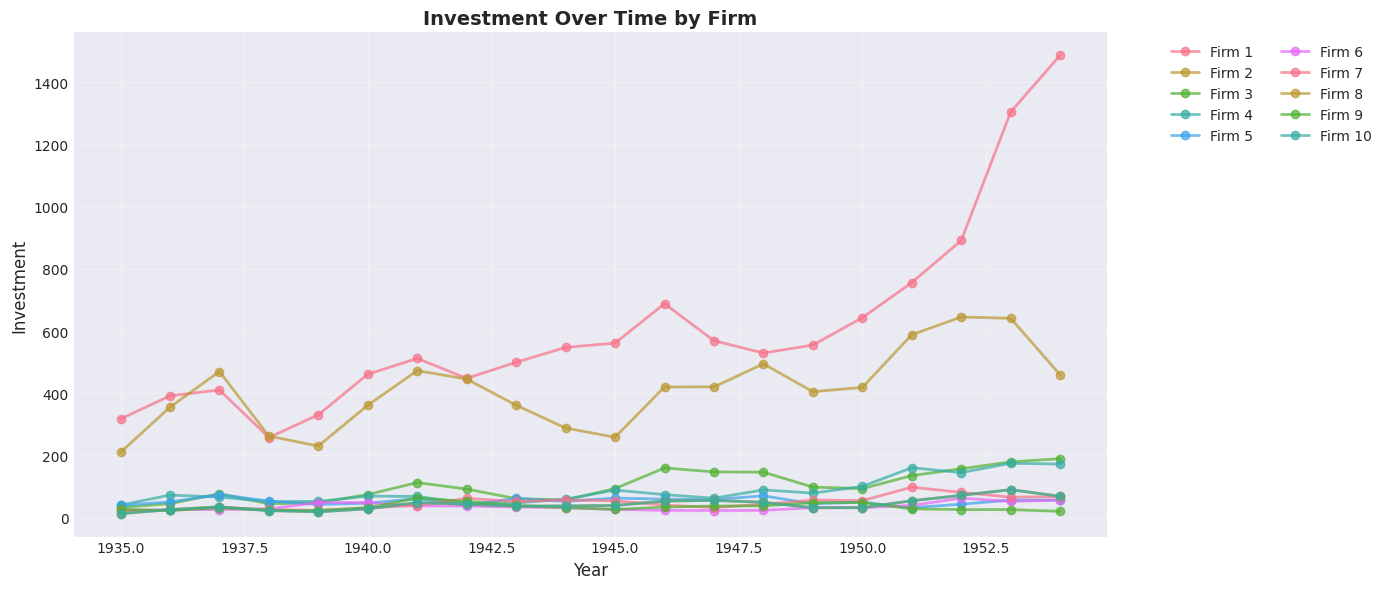

Observations:
- Clear firm-specific levels (between variation)
- Temporal trends within firms (within variation)
- This suggests Fixed Effects could be appropriate


In [6]:
# Investment trends by firm
fig, ax = plt.subplots(figsize=(14, 6))

for firm_id in data['firm'].unique():
    firm_data = data[data['firm'] == firm_id]
    ax.plot(firm_data['year'], firm_data['invest'], marker='o', label=f'Firm {firm_id}', alpha=0.7, linewidth=2)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Investment', fontsize=12)
ax.set_title('Investment Over Time by Firm', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("- Clear firm-specific levels (between variation)")
print("- Temporal trends within firms (within variation)")
print("- This suggests Fixed Effects could be appropriate")

---

## 3. The Five Models {#five-models}

We'll estimate all five models on the same specification:

$$\text{invest}_{it} = \beta_0 + \beta_1 \text{value}_{it} + \beta_2 \text{capital}_{it} + u_{it}$$

### 3.1 Pooled OLS {#pooled-ols}

**Pooled OLS** treats all observations as independent, ignoring the panel structure.

**Assumption**: $\alpha_i = 0$ (no firm-specific effects)

**Pros**:
- Simple
- Uses all variation (between + within)
- Baseline for comparison

**Cons**:
- ❌ Ignores unobserved heterogeneity
- ❌ Biased if $\alpha_i$ correlated with $X_{it}$
- ❌ Standard errors incorrect (need clustering)

In [7]:
# Estimate Pooled OLS
pooled = pb.PooledOLS(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)

pooled_results = pooled.fit()

print("="*70)
print("MODEL 1: POOLED OLS")
print("="*70)
print(pooled_results.summary())

MODEL 1: POOLED OLS
                        Pooled OLS Estimation Results                         
Formula: invest ~ value + capital
Model:   Pooled OLS
------------------------------------------------------------------------------
No. Observations:                 200
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:               197
R-squared:                     0.8090
Adj. R-squared:                0.8071
R-squared (overall):           0.8090
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept          -10.2135      8.7006  -1.174  0.2419  -27.3718    6.9448 
value                0.0951      0.0072  13.272  0.0000    0.0810    0.1092 ***
capital              0.2940      0.0327   8.980  0.0000    0.2295    0.3586 ***
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



**Interpretation**:
- Both `value` and `capital` are highly significant
- R² is high, suggesting good fit
- **BUT**: This assumes no firm-specific effects (likely violated)

### 3.2 Between Estimator {#between}

**Between Estimator** uses only cross-sectional variation by averaging over time for each firm.

**Method**: 
1. Calculate firm-specific means: $\bar{y}_i = \frac{1}{T}\sum_t y_{it}$
2. Run OLS on these means: $\bar{y}_i = \beta_0 + \beta' \bar{X}_i + u_i$

**Pros**:
- Captures long-run relationships
- Uses between variation
- Simple interpretation

**Cons**:
- ❌ Throws away all within variation
- ❌ Only N observations (not N×T)
- ❌ Inefficient compared to other estimators

In [8]:
# Estimate Between model
between = pb.BetweenEstimator(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)

between_results = between.fit()

print("="*70)
print("MODEL 2: BETWEEN ESTIMATOR")
print("="*70)
print(between_results.summary())

MODEL 2: BETWEEN ESTIMATOR
                     Between Estimator Estimation Results                     
Formula: invest ~ value + capital
Model:   Between Estimator
------------------------------------------------------------------------------
No. Observations:                  10
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:                 7
R-squared:                     0.9146
Adj. R-squared:                0.8902
R-squared (within):            0.0000
R-squared (between):           0.9146
R-squared (overall):           0.9351
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept           28.9214     30.3404   0.953  0.3722  -42.8223  100.6651 
value                0.3123      0.0802   3.894  0.0059    0.1226    0.5020 **
capital             -1.1933      0.5336  -2.236  0.0604  

**Interpretation**:
- Uses only 10 observations (firm averages)
- Captures differences between firms (long-run)
- Compare coefficients with Pooled OLS

### 3.3 Fixed Effects (FE) {#fixed-effects}

**Fixed Effects** is the workhorse of panel econometrics.

**Method**: Include firm dummies to control for $\alpha_i$

$$y_{it} = \alpha_i + \beta' X_{it} + \varepsilon_{it}$$

**Equivalently**: "Within" transformation (demean by firm)

$$(y_{it} - \bar{y}_i) = \beta' (X_{it} - \bar{X}_i) + (\varepsilon_{it} - \bar{\varepsilon}_i)$$

**Pros**:
- ✅ Controls for all time-invariant unobserved heterogeneity
- ✅ Consistent even if $\alpha_i$ correlated with $X_{it}$
- ✅ Uses within variation
- ✅ No distributional assumptions on $\alpha_i$

**Cons**:
- ❌ Cannot estimate time-invariant variables
- ❌ May remove too much variation
- ❌ Less efficient than RE if RE assumptions hold

In [9]:
# Estimate Fixed Effects
fe = pb.FixedEffects(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)

fe_results = fe.fit()

print("="*70)
print("MODEL 3: FIXED EFFECTS (WITHIN ESTIMATOR)")
print("="*70)
print(fe_results.summary())

MODEL 3: FIXED EFFECTS (WITHIN ESTIMATOR)
                       Fixed Effects Estimation Results                       
Formula: invest ~ value + capital
Model:   Fixed Effects
------------------------------------------------------------------------------
No. Observations:                 200
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:               188
R-squared:                     0.7899
Adj. R-squared:                0.7776
R-squared (within):            0.7899
R-squared (between):           1.0000
R-squared (overall):           0.9496
Standard Errors:            nonrobust
F-statistic (FE vs OLS):      58.2744
F-test p-value:                0.0000
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
value                0.1066      0.0113   9.401  0.0000    0.0842    0.1289 ***
capital              0.3444      0.0178  19.39

**Interpretation**:
- Coefficients differ from Pooled OLS (controlling for $\alpha_i$)
- Within R² shows fit after removing firm effects
- This is often the preferred estimator in practice

### 3.4 Random Effects (RE) {#random-effects}

**Random Effects** uses GLS estimation, treating $\alpha_i$ as random.

**Assumption**: $\alpha_i$ is **uncorrelated** with $X_{it}$

$$\mathbb{E}[\alpha_i | X_{i1}, ..., X_{iT}] = 0$$

**Method**: Quasi-demeaning with optimal weight $\theta$

$$(y_{it} - \theta\bar{y}_i) = \beta_0(1-\theta) + \beta'(X_{it} - \theta\bar{X}_i) + v_{it}$$

Where $\theta$ is chosen to minimize variance.

**Pros**:
- ✅ More efficient than FE (if assumption holds)
- ✅ Can estimate time-invariant variables
- ✅ Uses both between and within variation
- ✅ Better for small T

**Cons**:
- ❌ Inconsistent if $\alpha_i$ correlated with $X_{it}$
- ❌ Strong assumption (use Hausman test to check)

In [10]:
# Estimate Random Effects
re = pb.RandomEffects(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)

re_results = re.fit()

print("="*70)
print("MODEL 4: RANDOM EFFECTS (GLS ESTIMATOR)")
print("="*70)
print(re_results.summary())

MODEL 4: RANDOM EFFECTS (GLS ESTIMATOR)
                   Random Effects (GLS) Estimation Results                    
Formula: invest ~ value + capital
Model:   Random Effects (GLS)
------------------------------------------------------------------------------
No. Observations:                 200
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:               197
R-squared:                     0.8003
Adj. R-squared:                0.7983
R-squared (within):            0.7669
R-squared (between):           0.8037
R-squared (overall):           0.8003
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept          -25.3638      0.0294 -863.762  0.0000  -25.4217  -25.3059 ***
value                0.1006      0.0114   8.860  0.0000    0.0782    0.1230 ***
capital              0.3444      0.0

**Interpretation**:
- Coefficients typically between Pooled OLS and FE
- More efficient than FE (smaller standard errors) if assumption holds
- **Critical**: Use Hausman test to check if RE is valid

### 3.5 First Difference (FD) {#first-difference}

**First Difference** eliminates $\alpha_i$ by taking first differences.

**Method**: Transform to differences

$$\Delta y_{it} = y_{it} - y_{it-1} = \beta' \Delta X_{it} + \Delta \varepsilon_{it}$$

The $\alpha_i$ term drops out!

**Pros**:
- ✅ Eliminates $\alpha_i$ without demeaning
- ✅ Focuses on short-run changes
- ✅ Can handle non-stationarity
- ✅ Robust to certain forms of measurement error

**Cons**:
- ❌ Loses N observations (one per entity)
- ❌ Amplifies measurement error
- ❌ Less efficient than FE if errors are serially uncorrelated
- ❌ More efficient than FE if errors are random walk

In [11]:
# Estimate First Difference
fd = pb.FirstDifferenceEstimator(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)

fd_results = fd.fit()

print("="*70)
print("MODEL 5: FIRST DIFFERENCE")
print("="*70)
print(fd_results.summary())

MODEL 5: FIRST DIFFERENCE
                     First Difference Estimation Results                      
Formula: invest ~ value + capital
Model:   First Difference
------------------------------------------------------------------------------
No. Observations:                 190
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:               188
R-squared:                     0.4453
Adj. R-squared:                0.4424
R-squared (within):            0.4453
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
value                0.0892      0.0080  11.108  0.0000    0.0734    0.1051 ***
capital              0.3479      0.0495   7.032  0.0000    0.2503    0.4455 ***
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



**Interpretation**:
- Estimates effect of **changes** in X on **changes** in y
- Lost 10 observations (one per firm from differencing)
- Compare with FE to see if results are similar

---

## 4. Specification Tests {#specification-tests}

How do we choose between models? Use **specification tests**.

### 4.1 F-Test: Pooled OLS vs Fixed Effects

**Null hypothesis**: $\alpha_1 = \alpha_2 = ... = \alpha_N$ (Pooled OLS is adequate)

**Alternative**: At least one $\alpha_i$ differs (need Fixed Effects)

The F-statistic is automatically included in FE output. Let's check it:

In [12]:
# The F-test is now available in FE results!
print("F-Test: Pooled OLS vs Fixed Effects")
print("="*60)

# Extract F-statistic and p-value
f_stat = fe_results.f_statistic
f_pval = fe_results.f_pvalue

print(f"F-statistic:  {f_stat:.4f}")
print(f"P-value:      {f_pval:.4f}")
print()

if f_pval < 0.01:
    print("⭐ Strong evidence to REJECT H₀")
    print("   → Use Fixed Effects (entity effects are important)")
elif f_pval < 0.05:
    print("⭐ Evidence to REJECT H₀")
    print("   → Use Fixed Effects (entity effects are important)")
else:
    print("⭐ Cannot reject H₀")
    print("   → Pooled OLS may be adequate")

print()
print("Interpretation:")
print("  H₀: α₁ = α₂ = ... = αₙ (all entity effects are equal)")
print("  H₁: At least one αᵢ differs")
print()
print("The F-test compares the SSR from Pooled OLS vs Fixed Effects.")
print("A significant result means entity fixed effects are needed.")

F-Test: Pooled OLS vs Fixed Effects
F-statistic:  58.2744
P-value:      0.0000

⭐ Strong evidence to REJECT H₀
   → Use Fixed Effects (entity effects are important)

Interpretation:
  H₀: α₁ = α₂ = ... = αₙ (all entity effects are equal)
  H₁: At least one αᵢ differs

The F-test compares the SSR from Pooled OLS vs Fixed Effects.
A significant result means entity fixed effects are needed.


### 4.2 Hausman Test: Fixed Effects vs Random Effects

**Null hypothesis**: $\mathbb{E}[\alpha_i | X_{it}] = 0$ (RE is consistent and efficient)

**Alternative**: $\mathbb{E}[\alpha_i | X_{it}] \neq 0$ (RE is inconsistent, use FE)

**Test statistic**:

$$H = (\hat{\beta}_{FE} - \hat{\beta}_{RE})' [Var(\hat{\beta}_{FE}) - Var(\hat{\beta}_{RE})]^{-1} (\hat{\beta}_{FE} - \hat{\beta}_{RE}) \sim \chi^2_k$$

In [13]:
# Hausman Test
hausman = pb.HausmanTest(fe_results, re_results)

print("="*70)
print("HAUSMAN TEST: Fixed Effects vs Random Effects")
print("="*70)
print()

# The test is automatically run on initialization
# Access key statistics directly
print(f"Test Statistic (χ²): {hausman.statistic:.4f}")
print(f"P-value:             {hausman.pvalue:.4f}")
print(f"Degrees of Freedom:  {hausman.df}")
print()

# Interpretation
print("Decision:")
if hausman.reject_null:
    print("⭐ REJECT H₀ → Use Fixed Effects")
    print("   Evidence that Random Effects is inconsistent")
else:
    print("⭐ FAIL TO REJECT H₀ → Can use Random Effects")
    print("   No evidence of inconsistency, RE is more efficient")

print()
print(f"Recommendation: {hausman.recommendation}")
print()

# Show full summary
print(hausman.summary())

HAUSMAN TEST: Fixed Effects vs Random Effects

Test Statistic (χ²): -4.8601
P-value:             1.0000
Degrees of Freedom:  2

Decision:
⭐ FAIL TO REJECT H₀ → Can use Random Effects
   No evidence of inconsistency, RE is more efficient

Recommendation: Random Effects

HAUSMAN SPECIFICATION TEST

H0: Random Effects is consistent (and efficient)
H1: Random Effects is inconsistent (use Fixed Effects)

----------------------------------------------------------------------
Test Statistic (Chi2)                  -4.8601
P-value                                 1.0000
Degrees of Freedom                           2
----------------------------------------------------------------------

Conclusion: Fail to reject H0 at 5% level. Random Effects is consistent and efficient.
Recommendation: Random Effects

COEFFICIENT COMPARISON
Variable        Fixed Effects   Random Effects  Difference     
----------------------------------------------------------------------
capital                 0.3444      

**Practical Note**: 
- If Hausman test rejects (p < 0.05): Use **Fixed Effects**
- If Hausman test doesn't reject: Use **Random Effects** (more efficient)
- When in doubt: Use **Fixed Effects** (safer, always consistent)

---

## 5. Robust Standard Errors {#robust-se}

PanelBox supports **8 types of robust standard errors**:

1. **HC0-HC3**: Heteroskedasticity-robust (White standard errors)
2. **clustered**: Cluster-robust (by entity or time)
3. **driscoll_kraay**: Robust to spatial and temporal correlation
4. **newey_west**: HAC (heteroskedasticity and autocorrelation consistent)
5. **pcse**: Panel-corrected standard errors (Parks 1967)

Let's demonstrate the most common: **clustered standard errors**.

### 5.1 Clustered Standard Errors

In [14]:
# Fixed Effects with clustered SE (by firm)
fe_clustered = pb.FixedEffects(
    formula="invest ~ value + capital",
    data=data,
    entity_col="firm",
    time_col="year"
)

fe_clustered_results = fe_clustered.fit(cov_type='clustered', cluster_entity=True)

print("="*70)
print("FIXED EFFECTS WITH CLUSTERED STANDARD ERRORS")
print("="*70)
print(fe_clustered_results.summary())

FIXED EFFECTS WITH CLUSTERED STANDARD ERRORS
                       Fixed Effects Estimation Results                       
Formula: invest ~ value + capital
Model:   Fixed Effects
------------------------------------------------------------------------------
No. Observations:                 200
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:               188
R-squared:                     0.7899
Adj. R-squared:                0.7776
R-squared (within):            0.7899
R-squared (between):           1.0000
R-squared (overall):           0.9496
Standard Errors:            clustered
F-statistic (FE vs OLS):      58.2744
F-test p-value:                0.0000
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
value                0.1066      0.0142   7.493  0.0000    0.0785    0.1346 ***
capital              0.3444      0.0344  10

### 5.2 Compare Different Standard Errors

Let's see how different SE types affect inference:

In [15]:
# Estimate FE with different SE types
se_types = ['standard', 'HC0', 'HC1', 'HC2', 'HC3', 'clustered']
se_comparison = []

for se_type in se_types:
    model = pb.FixedEffects(
        formula="invest ~ value + capital",
        data=data,
        entity_col="firm",
        time_col="year"
    )
    
    if se_type == 'standard':
        results = model.fit()
    elif se_type == 'clustered':
        results = model.fit(cov_type='clustered', cluster_entity=True)
    else:
        results = model.fit(cov_type=se_type)
    
    se_comparison.append({
        'SE Type': se_type,
        'value SE': results.std_errors['value'],
        'capital SE': results.std_errors['capital']
    })

se_df = pd.DataFrame(se_comparison)
print("\nStandard Error Comparison:")
print("="*60)
print(se_df.to_string(index=False))

print("\nKey Observations:")
print("- Clustered SE are typically larger (more conservative)")
print("- HC variants adjust for heteroskedasticity")
print("- Choice matters for inference (t-stats, p-values)")


Standard Error Comparison:
  SE Type  value SE  capital SE
 standard    0.0113      0.0178
      HC0    0.0176      0.0410
      HC1    0.0177      0.0412
      HC2    0.0186      0.0462
      HC3    0.0198      0.0524
clustered    0.0142      0.0344

Key Observations:
- Clustered SE are typically larger (more conservative)
- HC variants adjust for heteroskedasticity
- Choice matters for inference (t-stats, p-values)


**When to use each:**

- **Standard**: Only if you're confident errors are i.i.d. (rare in panel data)
- **HC0-HC3**: Heteroskedasticity but no serial correlation
- **Clustered**: ⭐ **Recommended for panel data** (allows within-entity correlation)
- **Driscoll-Kraay**: Cross-sectional dependence (spatial correlation)
- **Newey-West**: Serial correlation with known lag structure
- **PCSE**: Panel-specific heteroskedasticity and serial correlation

---

## 6. Model Comparison {#model-comparison}

Let's create a comprehensive comparison table of all five models:

In [16]:
# Create comparison dataframe
comparison_data = {
    'Model': ['Pooled OLS', 'Between', 'Fixed Effects', 'Random Effects', 'First Diff'],
    'value_coef': [
        pooled_results.params['value'],
        between_results.params['value'],
        fe_results.params['value'],
        re_results.params['value'],
        fd_results.params['value']
    ],
    'value_se': [
        pooled_results.std_errors['value'],
        between_results.std_errors['value'],
        fe_results.std_errors['value'],
        re_results.std_errors['value'],
        fd_results.std_errors['value']
    ],
    'capital_coef': [
        pooled_results.params['capital'],
        between_results.params['capital'],
        fe_results.params['capital'],
        re_results.params['capital'],
        fd_results.params['capital']
    ],
    'capital_se': [
        pooled_results.std_errors['capital'],
        between_results.std_errors['capital'],
        fe_results.std_errors['capital'],
        re_results.std_errors['capital'],
        fd_results.std_errors['capital']
    ],
    'R²': [
        pooled_results.rsquared,
        between_results.rsquared,
        fe_results.rsquared_within,
        re_results.rsquared,
        fd_results.rsquared
    ],
    'N_obs': [
        pooled_results.nobs,
        between_results.nobs,
        fe_results.nobs,
        re_results.nobs,
        fd_results.nobs
    ]
}

comp_df = pd.DataFrame(comparison_data)

print("="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
print(comp_df.to_string(index=False))

print("\n" + "="*80)
print("NOTES:")
print("- Standard errors in parentheses")
print("- FE R² is within R² (after removing firm effects)")
print("- FD lost 10 observations from differencing")
print("- Between uses only 10 observations (firm means)")

MODEL COMPARISON TABLE
         Model  value_coef  value_se  capital_coef  capital_se     R²  N_obs
    Pooled OLS      0.0951    0.0072        0.2940      0.0327 0.8090    200
       Between      0.3123    0.0802       -1.1933      0.5336 0.9146     10
 Fixed Effects      0.1066    0.0113        0.3444      0.0178 0.7899    200
Random Effects      0.1006    0.0114        0.3444      0.0176 0.8003    200
    First Diff      0.0892    0.0080        0.3479      0.0495 0.4453    190

NOTES:
- Standard errors in parentheses
- FE R² is within R² (after removing firm effects)
- FD lost 10 observations from differencing
- Between uses only 10 observations (firm means)


### Visualize Coefficient Estimates

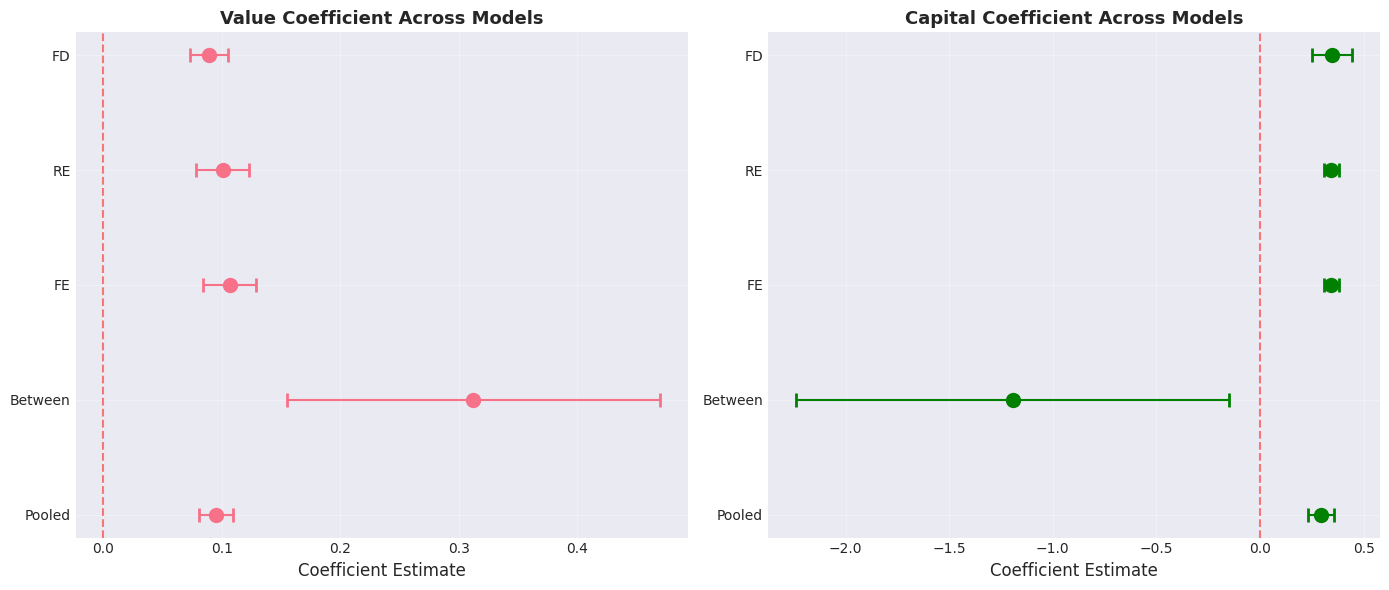

Key Observations:
- Pooled OLS often differs from FE/RE (omitted variable bias)
- FE and RE are often similar (but Hausman test is definitive)
- FD can differ if dynamics are important
- Between uses only cross-sectional variation


In [17]:
# Plot coefficients across models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models = ['Pooled', 'Between', 'FE', 'RE', 'FD']

# Value coefficient
value_coefs = comp_df['value_coef'].values
value_ses = comp_df['value_se'].values
y_pos = np.arange(len(models))

axes[0].errorbar(value_coefs, y_pos, xerr=1.96*value_ses, fmt='o', markersize=10, capsize=5, capthick=2)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(models)
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Coefficient Estimate', fontsize=12)
axes[0].set_title('Value Coefficient Across Models', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Capital coefficient
capital_coefs = comp_df['capital_coef'].values
capital_ses = comp_df['capital_se'].values

axes[1].errorbar(capital_coefs, y_pos, xerr=1.96*capital_ses, fmt='o', markersize=10, capsize=5, capthick=2, color='green')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(models)
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Coefficient Estimate', fontsize=12)
axes[1].set_title('Capital Coefficient Across Models', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print("- Pooled OLS often differs from FE/RE (omitted variable bias)")
print("- FE and RE are often similar (but Hausman test is definitive)")
print("- FD can differ if dynamics are important")
print("- Between uses only cross-sectional variation")

---

## 7. Report Generation {#report-generation}

PanelBox can export results to HTML, Markdown, and LaTeX.

### 7.1 HTML Report

In [18]:
# Generate HTML report (example - would save to file in practice)
print("HTML Export Example:")
print("="*60)
print("# To export to HTML:")
print("fe_results.to_html('fixed_effects_results.html')")
print("\n# This creates a professional, publication-ready HTML report")
print("# with tables, statistics, and formatting")

HTML Export Example:
# To export to HTML:
fe_results.to_html('fixed_effects_results.html')

# This creates a professional, publication-ready HTML report
# with tables, statistics, and formatting


### 7.2 LaTeX Export (for Academic Papers)

In [19]:
# Generate LaTeX table (example)
print("LaTeX Export Example:")
print("="*60)
print("# To export to LaTeX:")
print("fe_results.to_latex('table1.tex')")
print("\n# This creates a LaTeX table that can be directly")
print("# included in your paper with \\input{table1.tex}")
print("\n# You can also create comparison tables:")
print("from panelbox.report import create_comparison_table")
print("create_comparison_table([fe_results, re_results], 'comparison.tex')")

LaTeX Export Example:
# To export to LaTeX:
fe_results.to_latex('table1.tex')

# This creates a LaTeX table that can be directly
# included in your paper with \input{table1.tex}

# You can also create comparison tables:
from panelbox.report import create_comparison_table
create_comparison_table([fe_results, re_results], 'comparison.tex')


---

## 8. Decision Guide: Which Model to Use? {#decision-guide}

### Decision Tree:

```
Start Here
    |
    v
[Do you have panel data?]
    |
    YES --> [Are there unobserved entity effects?]
    |           |
    |           YES --> [Run F-test: Pooled vs FE]
    |           |           |
    |           |           Reject H₀ --> [Use FE or RE]
    |           |           |                  |
    |           |           |                  v
    |           |           |           [Run Hausman Test]
    |           |           |                  |
    |           |           |           Reject --> Fixed Effects ✓
    |           |           |           Don't Reject --> Random Effects ✓
    |           |           |
    |           |           Don't Reject --> Pooled OLS ✓
    |           |
    |           NO --> Pooled OLS ✓
    |
    NO --> Use standard regression
```

### Quick Reference Table:

| Situation | Recommended Model | Reason |
|-----------|------------------|--------|
| Just starting / exploratory | Pooled OLS | Baseline |
| Unobserved heterogeneity suspected | Fixed Effects | Safe, always consistent |
| Hausman test fails to reject | Random Effects | More efficient |
| Need to estimate time-invariant vars | Random Effects or Between | FE can't identify these |
| Short-run effects matter | First Difference | Focus on changes |
| Long-run effects matter | Between | Cross-sectional variation |
| Small T, large N | Random Effects | More efficient |
| Large T, small N | Fixed Effects | Asymptotic properties |
| When in doubt | Fixed Effects | Conservative choice |

### Best Practices:

1. **Always start with Fixed Effects** in applied work (unless you have strong reasons not to)
2. **Use clustered standard errors** (by entity) to be conservative
3. **Report multiple specifications** in papers (robustness)
4. **Test your assumptions** (F-test, Hausman test)
5. **Check diagnostics** (serial correlation, heteroskedasticity)
6. **Consider dynamics** (if lagged y matters, use GMM - see next notebook)

---

## Summary

In this notebook, you learned:

✅ **5 Static Panel Models**:
   - Pooled OLS (baseline)
   - Between (cross-sectional)
   - Fixed Effects (workhorse)
   - Random Effects (efficient if valid)
   - First Difference (short-run)

✅ **Specification Tests**:
   - F-test (Pooled vs FE)
   - Hausman test (FE vs RE)

✅ **Robust Standard Errors**:
   - 8 types available
   - When to use each
   - Clustered SE recommended

✅ **Model Comparison**:
   - How to compare models
   - Visualize differences
   - Interpretation

✅ **Report Generation**:
   - HTML, Markdown, LaTeX export
   - Publication-ready tables

### Next Steps:

- **[02_dynamic_gmm_complete.ipynb](./02_dynamic_gmm_complete.ipynb)**: Learn about dynamic panels and GMM
- **[03_validation_complete.ipynb](./03_validation_complete.ipynb)**: Deep dive into validation tests
- **[04_robust_inference.ipynb](./04_robust_inference.ipynb)**: Advanced inference techniques

---

*Happy modeling with PanelBox!*